In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import utils

In [35]:
print ("Started!!")

st = time.time()
symbols = utils.get_sap_symbols('sap500')
np.random.shuffle(symbols)
start_date="2013-10-01"
end_date="2016-10-01"
# use Open data
input_data = utils.get_data_list_key(symbols[:5], start_date, end_date)
target_data = utils.get_data('^OEX', start_date, end_date)['Open']
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
time for getting data: 6.98130989075


In [36]:
train_st = pd.Timestamp("2013-10-01")
train_end = pd.Timestamp("2015-10-01")
test_st = pd.Timestamp("2015-10-02")
test_end = pd.Timestamp("2016-10-01")

train_input = input_data.loc[(input_data.index >= train_st) & (input_data.index <= train_end)]
train_target = target_data.loc[(target_data.index >= train_st) & (target_data.index <= train_end)]
test_input = input_data.loc[(input_data.index >= test_st) & (input_data.index <= test_end)]
test_target = target_data.loc[(target_data.index >= test_st) & (target_data.index <= test_end)]

# MLP

In [37]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras import backend as K
# from keras.layers.core import K
tf.python.control_flow_ops = tf

class MLP(object):
    """using multisclae CNN, duplicate indicator"""
    def __init__(self, config):
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.n_stock = config.n_stock
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epochs = config.n_epochs
        self.lr = config.learning_rate
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
        
    def training(self, input_data, target_data):
        """training multi scale CNN with Adam Optimizer
        
        Args:
            data (list): stock prices for n_stock companies
        """
        # to use for prediciton keep input data
        stock_data = input_data.values
        target_data = target_data.values
        self.data = stock_data
        T = len(stock_data)
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
        print_freq = 100
        print ("training....")
        # index for shuffling
        indices = np.arange(T)
        for epoch in xrange(self.n_epochs):
            np.random.shuffle(indices)
            batch_indices = [indices[i: i + self.n_batch] for i in np.arange(0, T - self.n_batch, self.n_batch)]
            for idx in batch_indices:
                batch_input = [stock_data[t] for t in idx]
                batch_target = [target_data[t] for t in idx]
                # select transition from pool
                self.sess.run(self.optim, 
                              feed_dict={self.input: batch_input,
                                         self.target: batch_target,
                                         self.learning_rate: self.lr,
                                         K.learning_phase(): 1})  
            if epoch % print_freq == 0:
                print ("epoch:",  epoch)
                loss = self.sess.run(self.loss, feed_dict={self.input: stock_data,
                                                           self.target: target_data,
                                                          K.learning_phase(): 0})
                print ('loss_test:', loss)
        print ("finished")
        
    def predict(self, input_data):
        # to stabilize we use more than self.n_batch
        index = input_data.index
        data = input_data.values
        n_data = len(data)
        if n_data < self.n_batch:
            n_add = self.n_batch - n_data 
            data = np.concatenate((self.data[-n_add:], data))
        prediction = self.sess.run(self.output, feed_dict={self.input: data, 
                                                            K.learning_phase(): 0})[-n_data:]
        return pd.DataFrame(prediction, index=index)

    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.network = self.build_network()
        # transform input into the several scales and smoothing
        self.input =  tf.placeholder(tf.float32, [None, self.n_stock], name='input')
        self.target = tf.placeholder(tf.float32, [None], name='target')
        network_output = self.network(self.input)
        self.output = tf.reduce_sum(network_output * self.input, 1)
        self.loss = tf.reduce_mean((self.output - self.target)**2)
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss)
        tf.initialize_all_variables().run(session=self.sess)
            
        
    def build_network(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # layer1
        # raw input
        model = Sequential()
        model.add(Dense(200, input_shape=(self.n_stock,)))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer2
        model.add(Dense(200))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer3
        model.add(Dense(200))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(100))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(self.n_stock))
        return model

    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False


In [38]:
n_stock = len(train_input.values[0])

class MSCNNConfig(object):
    device = '/cpu:0'
    save_path = '/home/tomoaki/work/github/Indicator_Analysis/model.ckpt'
    is_load = False
    activation = 'relu'
    gamma = 0.99
    history_length = 10
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 1000
    n_feature = 32
    alpha = 0.7
    beta = 0.5
    update_rate = 1e-2
    learning_rate = 1e-3

In [39]:
%%time
import warnings
warnings.filterwarnings("ignore")

config = MSCNNConfig()
mlp = MLP(config)
mlp.training(train_input, train_target)

building model....
finished building model!
training....
epoch: 0
loss_test: 12426.4
epoch: 100
loss_test: 146.914
epoch: 200
loss_test: 110.33
epoch: 300
loss_test: 95.771
epoch: 400
loss_test: 150.599
epoch: 500
loss_test: 104.493
epoch: 600
loss_test: 120.485
epoch: 700
loss_test: 55.9181
epoch: 800
loss_test: 40.7497
epoch: 900
loss_test: 40.0324
finished
CPU times: user 2min 59s, sys: 9.46 s, total: 3min 8s
Wall time: 1min 22s


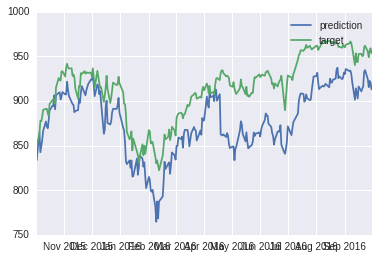

In [40]:
prediction = mlp.predict(test_input)
plt.plot(prediction, label='prediction')
plt.plot(test_target, label='target')
plt.legend()

In [5]:
a = np.random.randn??

In [6]:
a = np.random.randn(10, 10)

In [8]:
a[-1:]

array([[-0.77005504, -0.64673734, -2.35499318, -0.41608836,  0.59727401,
        -0.88288025,  0.63404298,  1.6629723 , -0.3622952 , -0.06545881]])

In [ ]:
class SearchConfig:
    history_length=[8, 64]
    learning_rate=[1e-3, 10]
    leraning_anneal=[3.0e2, 3.0e4]
    n_feature=[18, 1024]
    n_filter=[2, 8]
    n_hidden=[18, 1024]

In [ ]:
import numpy as np

def sample_geo(conf):
    low = conf[0]
    high = conf[1]
    u = np.random.uniform()
    return np.exp((np.log(high / low) * u + np.log(low)))

In [ ]:
def make_train(data, hl):
    return np.array([data[i:i+hl] for i in xrange(len(data) - hl + 1)])